# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [6]:
#your code here

#load training data
airbnb_train = pd.read_csv("../data/calendar_train.csv", parse_dates=['date']).dropna().sort_values('date')

#add weekend column indicating whether the date falls on Friday or Staturday
weekend = np.array(airbnb_train.date.dt.weekday)
friday = weekend == 4
saturday = weekend == 5
airbnb_train['weekend'] = friday + saturday

#load test data
airbnb_test = pd.read_csv("../data/calendar_test.csv", parse_dates=['date']).dropna().sort_values('date')

#add weekend column indicating whether the date falls on Friday or Staturday
weekend = np.array(airbnb_test.date.dt.weekday)
friday = weekend == 4
saturday = weekend == 5
airbnb_test['weekend'] = friday + saturday

#size and the data sample
print(airbnb_train.shape)
airbnb_train.head()

(309288, 5)


,listing_id,date,available,price,weekend
723059,4075898,2017-10-06,t,289.0,True
197230,20830101,2017-10-06,t,605.0,True
290785,4624582,2017-10-06,t,40.0,True
178897,12383204,2017-10-06,t,583.0,True
197748,4445906,2017-10-06,t,519.0,True


### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

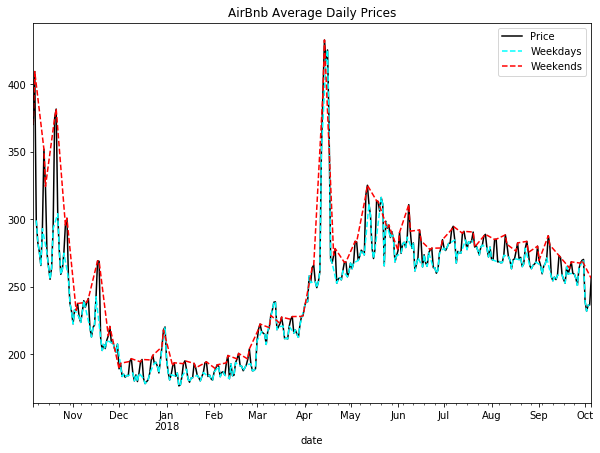

TypeError: Locale must be None, a string, or an iterable of two strings -- language code, encoding.

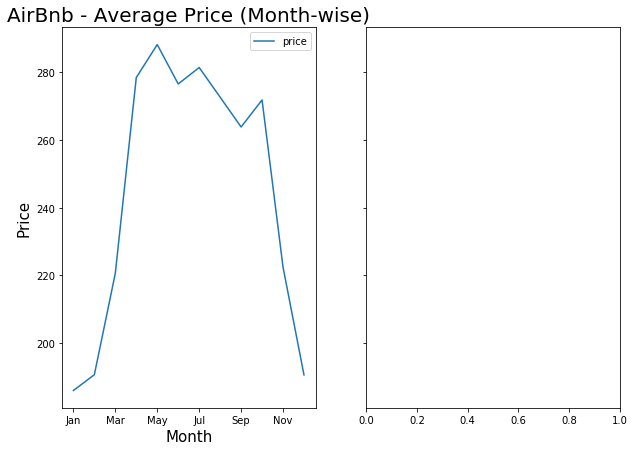

In [8]:
import calendar

#average the data across date for visualization and plot the data
daily_average_train = airbnb_train[['date', 'price', 'weekend']].groupby(by=['date'], sort=True).mean()

ax = plt.subplot(1,1,1)
daily_average_train.plot(figsize=(10,7), title='AirBnb Average Daily Prices', 
                         ax=ax, label='Average Price', c='black')

daily_average_train[daily_average_train.weekend==0].plot(ls='--', ax=ax, label='Weekdays', c='cyan')
daily_average_train[daily_average_train.weekend==1].plot(ls='--',ax=ax, label='Weekends', c='red')
ax.legend(['Price', 'Weekdays', 'Weekends'])
plt.show()

monthly_average_price = airbnb_train.dropna()[['date', 
                                               'price']].groupby(by=[airbnb_train.date.dt.month],
                                                                 sort=True).mean()
monthly_average_price = monthly_average_price.rename(index=lambda x: calendar.month_abbr[x])

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1 = monthly_average_price.plot(title='AirBnb - Average Price (Month-wise)', figsize=(10,7), ax=ax1)
ax1.title.set_size(20)
ax1.set_xlabel('Month', fontsize=15)
ax1.set_ylabel('Price', fontsize=15)

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
day_of_week_average_price = airbnb_train.dropna()[['date', 
                                                   'price']].groupby(by=[airbnb_train.date.dt.day_name],
                                                                    ).mean().reindex(days)
ax2 = day_of_week_average_price.plot(title='AirBnb - Average Price (Day-wise)', figsize=(10,7), ax=ax2)
ax2.title.set_size(20)
ax2.set_xlabel('Day of the Week', fontsize=15)
ax2.set_ylabel('Price', fontsize=15)
plt.show()

# Analysis

* Average prices are decidedly higher during the US summer months April through Sep. May could be on account of college graduation and the high concentration of colleges in Boston. This is on account of weekdays and weekends both. April is likely higher due to Boston Marathon.

* The prices drop by nearly 30% during the winter months which is a bit surprising considering Christmas holidays but weather is possibly a dominating factor. Further December maybe cheaper on account of the short-term increase in supply due to students traveling and offerign their accomodation on temporary lease.

* Weekend prices are about 10% higher than weekday prices and start to dip on Sunday which is probably on account of the work-week starting Monday. 

* Average prices are more volatile across months whereas across weekdays volatility is much lower,  i.e. Weekend effect is smaller than weather or time of the year effect.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1EDA
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>good 
</span></div>
</div>

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [9]:
airbnb_train.date = (airbnb_train.date - airbnb_train.date.min()).dt.days
airbnb_test.date = (airbnb_test.date - airbnb_test.date.min()).dt.days
airbnb_test.head()

,listing_id,date,available,price,weekend
19754,11968079,0,t,480.0,True
222955,19159772,0,t,342.0,True
160584,10117329,0,t,545.0,True
19633,1867881,0,t,469.0,True
44970,9992532,0,t,583.0,True


### 1. Polynomials


##########################################################
Polynomial Regression with Degree = 2
Training R-Squared                = 0.0185
Testing R-Squared                 = 0.0192


np.vander(date, 3, increasing=True)[0]    206.093239
np.vander(date, 3, increasing=True)[1]      0.079469
np.vander(date, 3, increasing=True)[2]      0.000463
dtype: float64


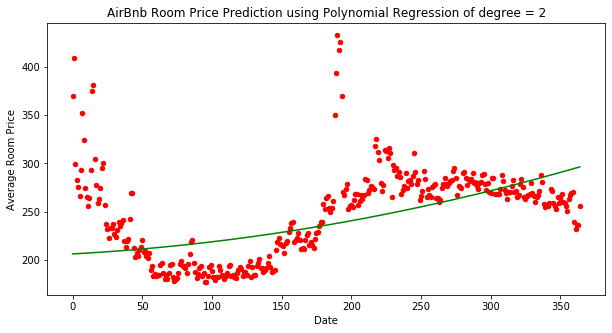


##########################################################
Polynomial Regression with Degree = 3
Training R-Squared                = 0.0389
Testing R-Squared                 = 0.0388


np.vander(date, 4, increasing=True)[0]    297.346254
np.vander(date, 4, increasing=True)[1]     -2.543320
np.vander(date, 4, increasing=True)[2]      0.017967
np.vander(date, 4, increasing=True)[3]     -0.000032
dtype: float64


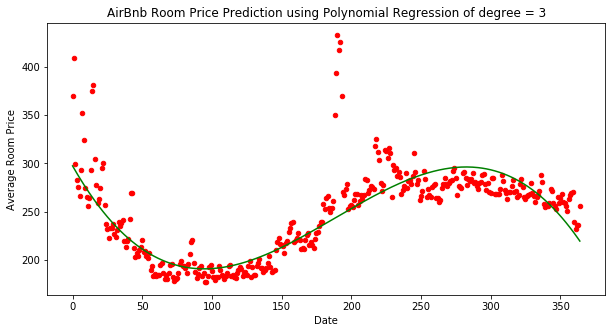


##########################################################
Polynomial Regression with Degree = 5
Training R-Squared                = 0.0421
Testing R-Squared                 = 0.0417


np.vander(date, 6, increasing=True)[0]    3.180886e+02
np.vander(date, 6, increasing=True)[1]   -3.059272e+00
np.vander(date, 6, increasing=True)[2]    1.546791e-02
np.vander(date, 6, increasing=True)[3]    5.116205e-05
np.vander(date, 6, increasing=True)[4]   -4.095472e-07
np.vander(date, 6, increasing=True)[5]    5.842781e-10
dtype: float64


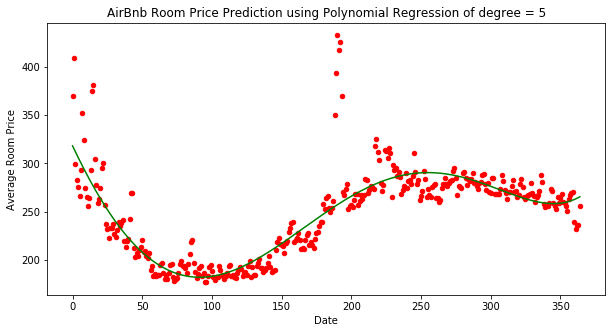


##########################################################
Polynomial Regression with Degree = 8
Training R-Squared                = -0.1702
Testing R-Squared                 = -0.1580


np.vander(date, 9, increasing=True)[0]    6.821084e-09
np.vander(date, 9, increasing=True)[1]    4.086062e-07
np.vander(date, 9, increasing=True)[2]    2.782441e-05
np.vander(date, 9, increasing=True)[3]    1.084526e-03
np.vander(date, 9, increasing=True)[4]   -1.522060e-05
np.vander(date, 9, increasing=True)[5]    8.210821e-08
np.vander(date, 9, increasing=True)[6]   -1.972756e-10
np.vander(date, 9, increasing=True)[7]    1.764666e-13
np.vander(date, 9, increasing=True)[8]    1.623329e-18
dtype: float64


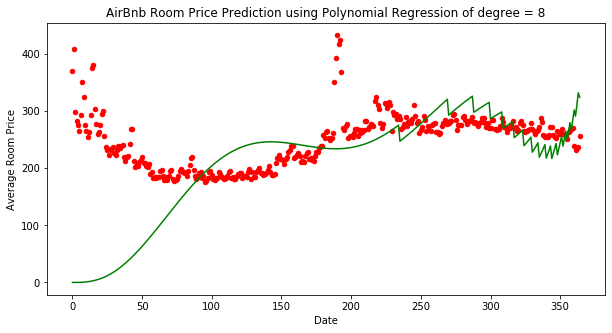


##########################################################


In [11]:
#your code here

degrees = [2, 3, 5, 8]

daily_average_price_train = airbnb_train[['date','weekend',
                                          'price']].groupby(by=[airbnb_train.date], 
                                                            sort=True).mean()
daily_average_price_test = airbnb_test[['date','weekend',
                                        'price']].groupby(by=[airbnb_train.date],
                                                          sort=True).mean()

poly_reg = []

for degree in degrees:
    formula = 'price ~ np.vander(date, {}, increasing=True) - 1'.format(degree+1)
    model = sm.ols(formula=formula, data=airbnb_train).fit()
    print("\n##########################################################")
    print("Polynomial Regression with Degree = {}".format(degree))
    print("Training R-Squared                = {:1.4f}".format(model.rsquared))
    pred_test = model.get_prediction(airbnb_test)
    prediction_output = model.get_prediction(daily_average_price_train).summary_frame()
    print("Testing R-Squared                 = {:1.4f}".format(r2_score(airbnb_test.price, pred_test.predicted_mean)))
    
    print("\n")
    print(model.params)
    
    ax1 = daily_average_price_train.plot.scatter(x='date',y='price',c='Red', figsize=(10,5),
                                                 title="AirBnb Room Price Prediction using Polynomial " +
                                                 "Regression of degree = {}".format(degree))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Average Room Price")

    ax1.plot(daily_average_price_train.date, prediction_output['mean'],color="green")
    plt.show()
    
print("\n##########################################################")

# Analysis

Polynomial Degree | Training $R^{2}$ | Testing $R^{2}$ | Comments|
------------------|------------------|-----------------|---------
2| 0.0185 | 0.0192 | Model is not a good fit
3| 0.0389 | 0.0388 | Model performs much better than quadratic but have room for improvement
5| 0.0421 | 0.0417 | This is the best fit both in terms of $R^{2}$ and visual fit
8| -0.1702 | -0.0158 | Apart from overfitting, this model adds additional volatilty then there is in the training data

1. **Red dots in the graphs above are the average room prices for the given date**

2. **Green line is the model prediciton based on the training data**

### 2. Degree 8 oddity

# Analysis

#### Answer 

* **Lets look at the 8th degree term i.e. $x^{8}$.**
    - $x$ ranges from $0$ to $365$, which means $x^{8}$ ranges from $0$ to $365^{8}$.


* **Discrepancy between prediction error for lower $x$ values vs. higher $x$ values**
    - Polynomial Regression being a form of linear regression minimizes the average squared distance between actual and predicted value.
    - Given the large values of $x^{8}$, the optimization algorithim gives more credence to $x^{8}$ terms than to lower order terms to minimize the sum of squared errors.
    - Further more importance is given to large vlaues of $x$ as incorrect $\beta$ computation is more penalizing for such large values. For example, if error in $\beta$ is $\epsilon$ the impact on prediction is $\epsilon * x^{8}$. For $x=0$ the impact is $0$, where as for $x=365$ impact is $\epsilon * 365^{8}$. Hence optimization algorithim automatically gives more weightage to larger values of $x$. 
    - This results in larger prediction errors for low values of $x$ and smaller prediction error for large values of $x$ as depicted in the plot.


* **Intercept going to zero**
    - Further compared to $x^{8}$, $y$ i.e. $price$ does not blow up and hence to minimize the error term, all the $\beta_i$ coefficients including $\beta_0$ are pulled towards $0$.
    - As we keep increasing the degree beyond the degree of true function, higher order polynomials result in smaller coefficient values across the board as compared to lower order polynomials.
    - This pull towards zero starts with coefficients of higher order terms but soon that is not enough to minimize the squared error and leads to lower order coefficients being pulled to zero.

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In [ ]:
#your code here

smoothings = np.logspace(-3, 6, 9)
cv = 10

kf = KFold(n_splits=cv, random_state=42, shuffle=True)
scores = np.zeros((cv,len(smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(airbnb_train)):
    train_df = airbnb_train.iloc[train_index,:]
    test_df = airbnb_train.iloc[test_index,:]
    
    for j, smoothing in enumerate(smoothings):
        cur_model = LinearGAM(s(0), lam=smoothing).fit(train_df.date, train_df.price)
        scores[i,j] = r2_score(test_df.price, cur_model.predict(test_df.date))


for j, smoothing in enumerate(smoothings):
    cur_model = LinearGAM(s(0), lam=smoothing).fit(airbnb_train.date, airbnb_train.price)
    rscore = np.mean(scores[:,j])
    res = cur_model.deviance_residuals(daily_average_price_train.date, daily_average_price_train.price)

    for k, term in enumerate(cur_model.terms):
        if term.isintercept:
            continue

        XX = cur_model.generate_X_grid(term=k)
        pdep, confi = cur_model.partial_dependence(term=k, X=XX, width=0.95)
        pdep2, _ = cur_model.partial_dependence(term=k, X=daily_average_price_train.date, width=0.95)
        plt.figure(figsize=(10,7))
        plt.scatter(daily_average_price_train.iloc[:,term.feature], pdep2 + res, c='red')
        plt.plot(XX[:, term.feature], pdep, c='green')
        plt.plot(XX[:, term.feature], confi, c='skyblue', ls='--')
        plt.title('Spline Model with Smoothness Parameter (lambda) = ' + 
                  '{:0.3f} and Cross Validation R-Squared = {:0.5f}'.format(smoothing, rscore), fontsize=15)
        plt.xlabel(daily_average_price_train.columns.values[term.feature])
        plt.ylabel('price')
        plt.show()


best_lambda = smoothings[np.argmax(np.mean(scores, axis=0))]

airbnb_gam = LinearGAM(s(0), lam=best_lambda).fit(airbnb_train.date, airbnb_train.price)
r_score_train = r2_score(airbnb_train.price, airbnb_gam.predict(airbnb_train.date))
r_score_test = r2_score(airbnb_test.price, airbnb_gam.predict(airbnb_test.date))

print(airbnb_gam.summary())
print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')

res = airbnb_gam.deviance_residuals(daily_average_price_train.date, daily_average_price_train.price)
for i, term in enumerate(airbnb_gam.terms):
    if term.isintercept:
        continue

    XX = airbnb_gam.generate_X_grid(term=i)
    pdep, confi = airbnb_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = airbnb_gam.partial_dependence(term=i, X=daily_average_price_train.date, width=0.95)
    plt.figure(figsize=(15,10))
    plt.scatter(daily_average_price_train.iloc[:,term.feature], pdep2 + res, c='red')
    plt.plot(XX[:, term.feature], pdep, c='green')
    plt.plot(XX[:, term.feature], confi, c='skyblue', ls='--')
    plt.title('Selected Spline Model with K-Fold Cross Validated Smoothness Parameter (lambda) = ' +
              '{:0.3f},\n Training R-Squared = {:0.5f}, and Test R-Squared = {:0.5f}'.format(best_lambda, 
                                                                                             r_score_train, 
                                                                                             r_score_test),
              fontsize=20)
    
    plt.xlabel(daily_average_price_train.columns.values[term.feature])
    plt.ylabel('price')
    plt.show()

# Analysis

K (no of folds)|$\lambda$|$R^{2}$ (Shuffle=False)|$R^{2}$ (Shuffle=True)
---------------|---------|-----------------------|----------------------
10|0.001| -0.05720|0.04481
10|0.013|-0.05696|0.04481
10|0.178|-0.05392)|0.04481
10|2.371|-0.0298|0.04481
10|31.623|-0.00232|0.04471
10|421.697|0.00007|0.04405
10|5623.413|-0.00239|0.04341
10|74989.421|-0.00828|0.04114
10|1000000|-0.037085|0.02769

1. **Best value for $\lambda$ (i.e. smoothing parameter) for Shuffle=False: 421.697**
2. **Best value for $\lambda$ (i.e. smoothing parameter) for Shuffle=True: 0.1778**

**Please note that graphs above and the problems below have been solved using the results from *shuffle=True*.**
* **shuffle=True** in **KFold** ignores the time-series nature of the data and most likely overfits in comparison to **shuffle=False**.
* Using **shuffle=True** as per the guidance of TA during online office hours.

### 4. Effects of parameters

# Analysis

#### Answer

Model| Parameter | Training $R^{2}$ | Testing $R^{2}$ 
-----|------------|------------------|---------------
Polynomial Regression|Degree = 5| 0.0421 | 0.0417 
Linear GAM|$\lambda$ = 0.1778| 0.0450 | 0.0448

**Which model performs better?**
1. On both $training R^{2}$ and $testing R^{2}$, LinearGAM outperforms Polynomial regression, however the the difference is not very significant.
2. LinearGAM fit is very wiggly compared to 5-degree polynomial and might be overfittng the data.
3. If we use **shuffle=False** i.e. $\lambda$ = 421.697, while there is slight drop in $R^{2}$, the fit is much more smoother.

**What is the effect of the tuning parameters (degree and smoothness penalty)?**
1. As we increase the degree of the polynomial regression, the fit become more and more wiggly. Initialy increasing the degree helps capture the non linear nature of the data. However, soon the model starts overfitting and the curve become wiggly. $degree =1$ is equivalent of linear regression.
2. $\lambda$ or smoothness penalty in case of LinearGAM works in the opposite manner. As we increase $\lambda$ the curve starts becoming less and less wiggly. At $\lambda = \infty$, LinearGAM is equivalent of linear regression and is completely ignoring any non-linear nature of the data. At $\lambda = 0$, the fit is at its most wiggly and is most likely overfitting the data by treating random noise in the data as an actual information. Increasing $\lambda$ lowers the effective degree of freedom of the fit.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1a
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'> good
</span></div></div>

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


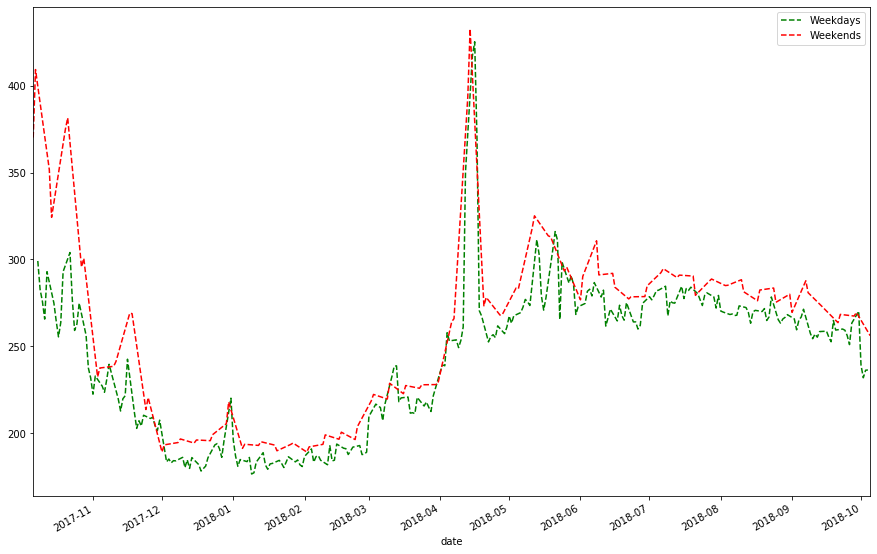


###########################################################

Training R-Squared = 0.04612
Testing R-Squared = 0.04616

###########################################################

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      20.916
Link Function:                     IdentityLink Log Likelihood:                              -3510509.7357
Number of Samples:                       309288 AIC:                                          7021063.3034
                                                AICc:                                         7021063.3067
                                                GCV:                                            33909.9063
                                                Scale:                

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



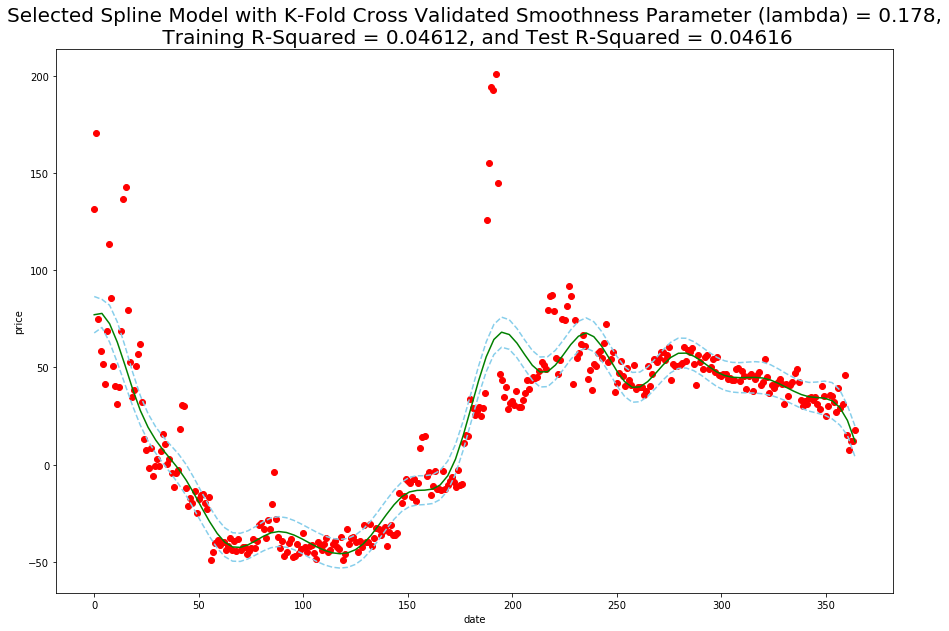

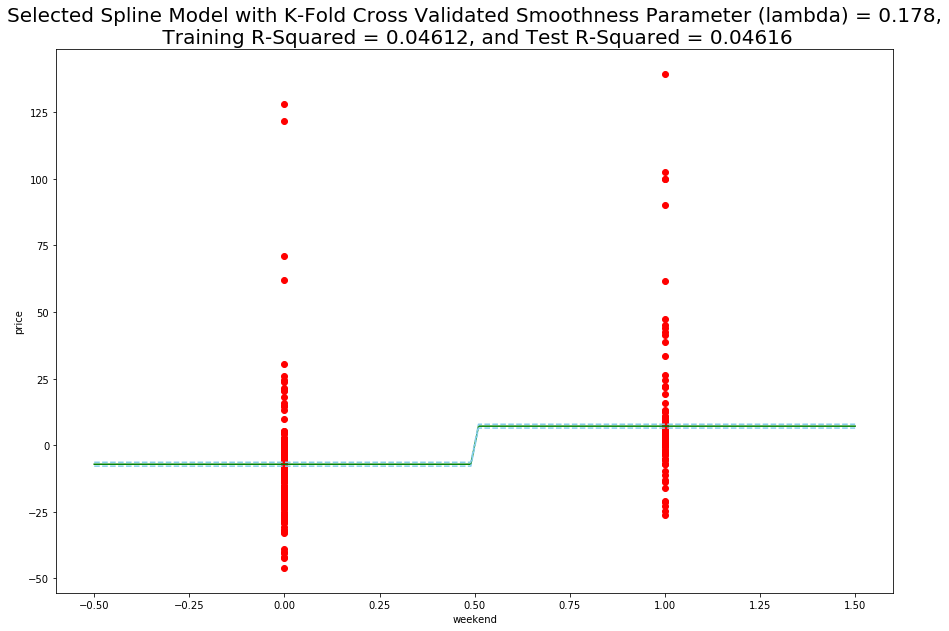

In [8]:
#your code here

ax = plt.subplot(1,1,1)
daily_average_train[daily_average_train.weekend==0].plot(figsize=(15,10), ls='--', ax=ax, label='Weekdays', c='green')
daily_average_train[daily_average_train.weekend==1].plot(ls='--',ax=ax, label='Weekends', c='red')
ax.legend(['Weekdays', 'Weekends'])
plt.show()

airbnb_gam = LinearGAM(s(0) + f(1), lam=best_lambda).fit(airbnb_train[['date','weekend']], airbnb_train.price)
r_score_train = r2_score(airbnb_train.price, airbnb_gam.predict(airbnb_train[['date','weekend']]))
r_score_test = r2_score(airbnb_test.price, airbnb_gam.predict(airbnb_test[['date','weekend']]))

print('\n###########################################################\n')
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(airbnb_gam.summary())

res = airbnb_gam.deviance_residuals(daily_average_price_train[['date','weekend']], daily_average_price_train.price)
for i, term in enumerate(airbnb_gam.terms):
    if term.isintercept:
        continue

    XX = airbnb_gam.generate_X_grid(term=i)
    pdep, confi = airbnb_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = airbnb_gam.partial_dependence(term=i, X=daily_average_price_train[['date','weekend']], width=0.95)
    plt.figure(figsize=(15,10))
    plt.scatter(daily_average_price_train.iloc[:,term.feature], pdep2 + res, c='red')
    plt.plot(XX[:, term.feature], pdep, c='green')
    plt.plot(XX[:, term.feature], confi, c='skyblue', ls='--')
    plt.title('Selected Spline Model with K-Fold Cross Validated Smoothness Parameter (lambda) = ' +
              '{:0.3f},\n Training R-Squared = {:0.5f}, and Test R-Squared = {:0.5f}'.format(best_lambda,
                                                                                             r_score_train, 
                                                                                             r_score_test), 
              fontsize=20)
    
    plt.xlabel(daily_average_price_train.columns.values[term.feature])
    plt.ylabel('price')
    plt.show()

# Analysis

Model| Parameter | Training $R^{2}$ | Testing $R^{2}$ 
-----|------------|------------------|---------------
Polynomial Regression|Degree = 5| 0.0421 | 0.0417 
Linear GAM (without Weekend factor)|$\lambda$ = 0.1778| 0.0450 | 0.0448
Linear GAM (with Weekend factor)|$\lambda$ = 0.1778| 0.0461 | 0.0462

#### Comment for 1b

* As we can see from the plots as well as LinearGAM model above, there is a clear weekend effect.

* Weekend prices are consistently higher than the weekday prices

* Further adding weekend as a factor increases both $training R^{2}$ and $testing R^{2}$.

* The overall $R^{2}$ values continue to be low; and hence it is likely that date by itself does not explain the variation and that there are other factors which have a greater effect across all dates. 

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1b
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>good
</span></div>
</div>

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [9]:
daily_average_train.sort_values(by=['price'], ascending=False).head(10).sort_values('date')

,price,weekend
date,,
2017-10-06,370.173410,True
2017-10-07,409.298701,True
2017-10-13,351.800725,True
2017-10-20,374.955932,True
2017-10-21,381.526515,True
2018-04-13,393.609047,True
2018-04-14,432.680761,True
2018-04-15,417.170404,False
2018-04-16,425.289528,False


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1c
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>good
</span></div>
</div>

# Analysis

### Comment 1c

* 7 out of 10 dates lie on a weekend, and further April 15th 2018 is a public holday and being Monday makes that weekend a long weekend.
* April 13 through 17 prices are high which is likely on account of the Patriots' Day long weekend and Boston Marathon which attracts over 30K participants plus visitors leading to high demand.

* During Oct 21-23, 2017 American Society of Anesthesiologists was holding its annual meeting in Boston with 18K attendees. This could have contributed to higher prices during the weekend of Oct 20-21, 2017.

* The three remaining high average price dates are on the weekends and may also incorporate noise or other information.

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [10]:
#load training data
listing_train = pd.read_csv("./data/listings_train.csv").dropna()

#load test data
listing_test = pd.read_csv("./data/listings_test.csv").dropna()

listing_train.head()

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


/usr/share/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/share/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


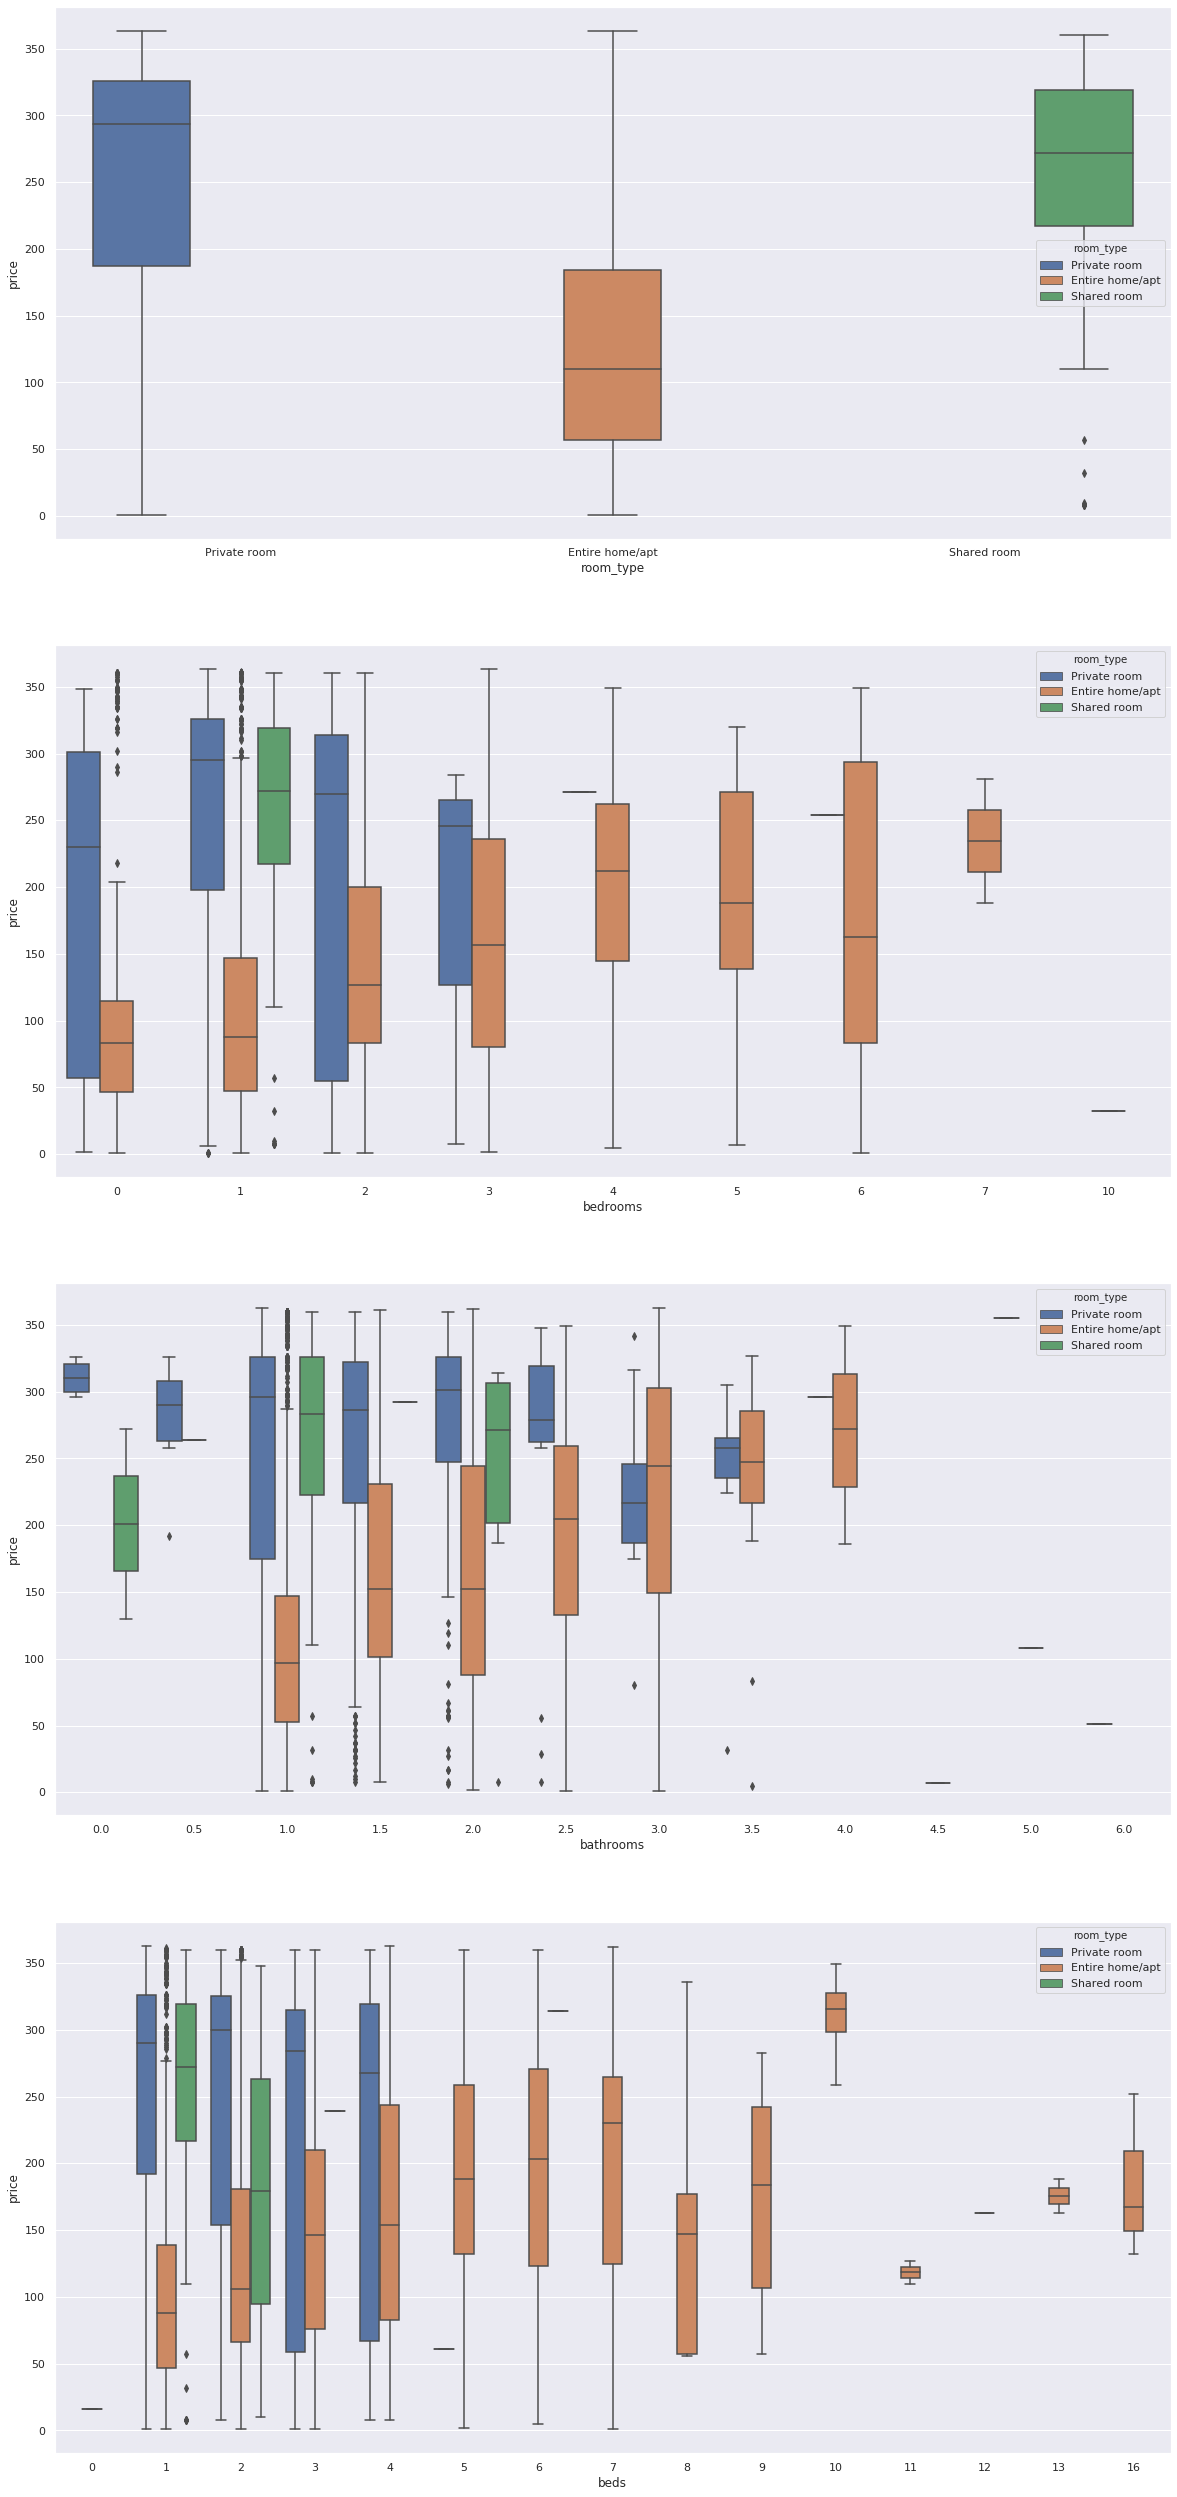

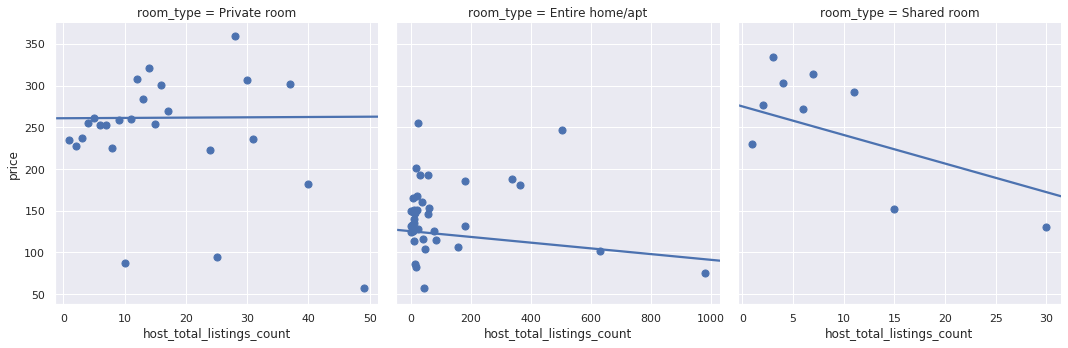

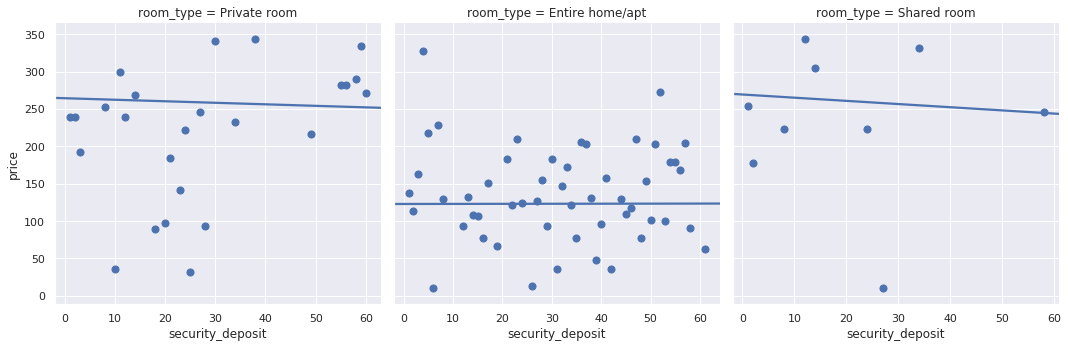

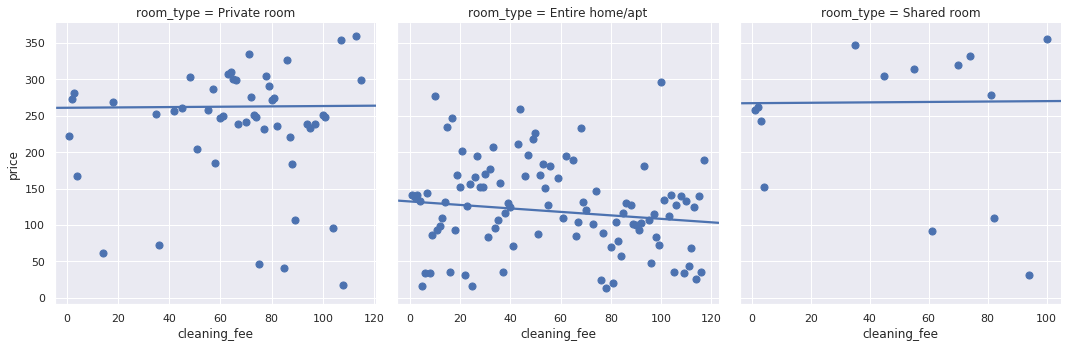

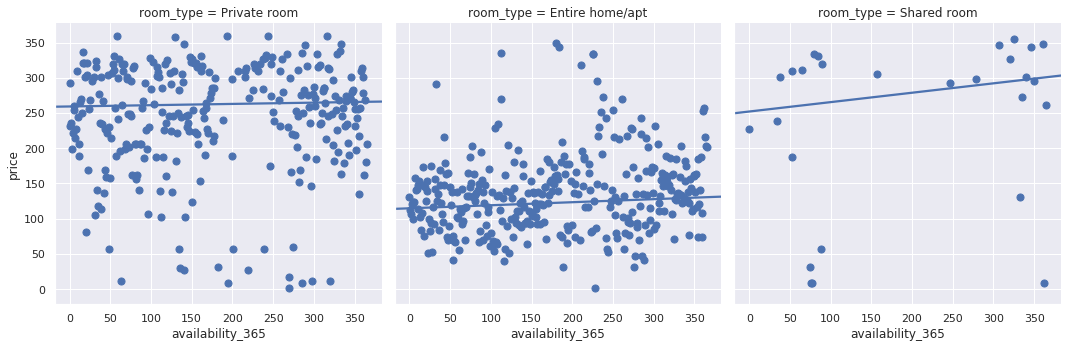

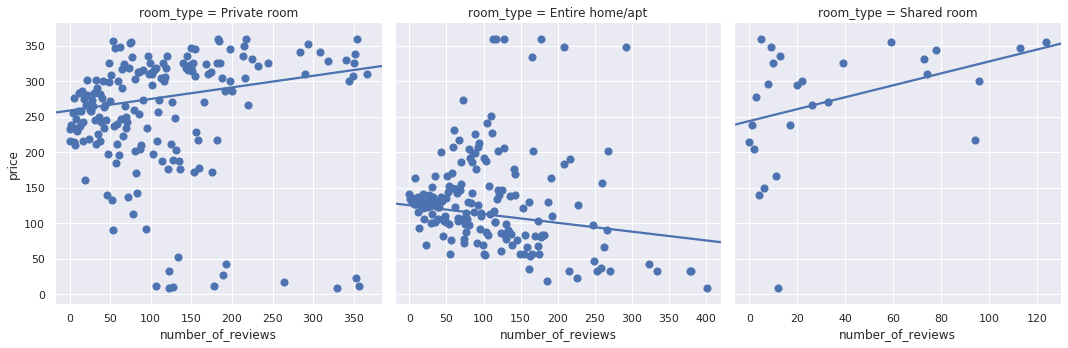

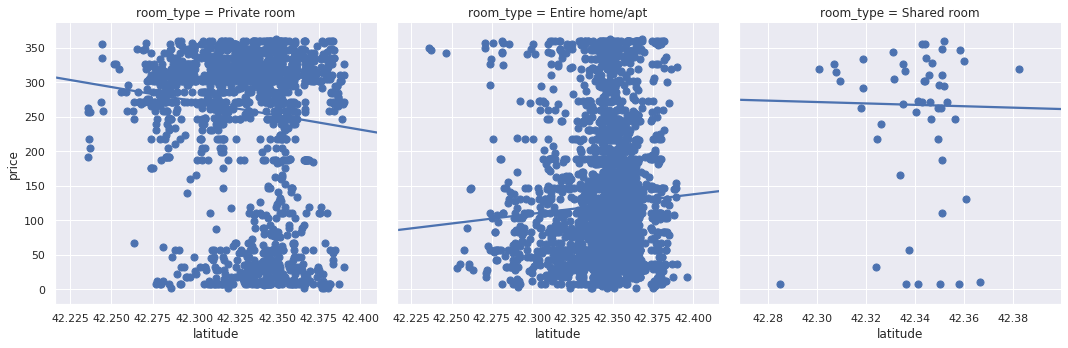

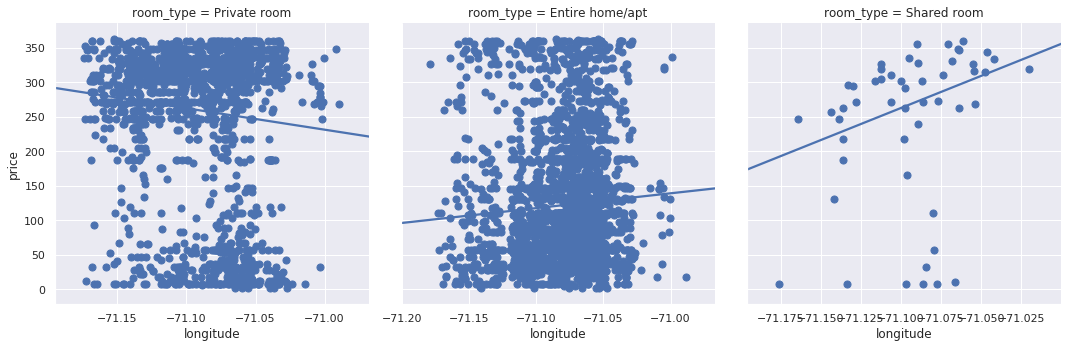

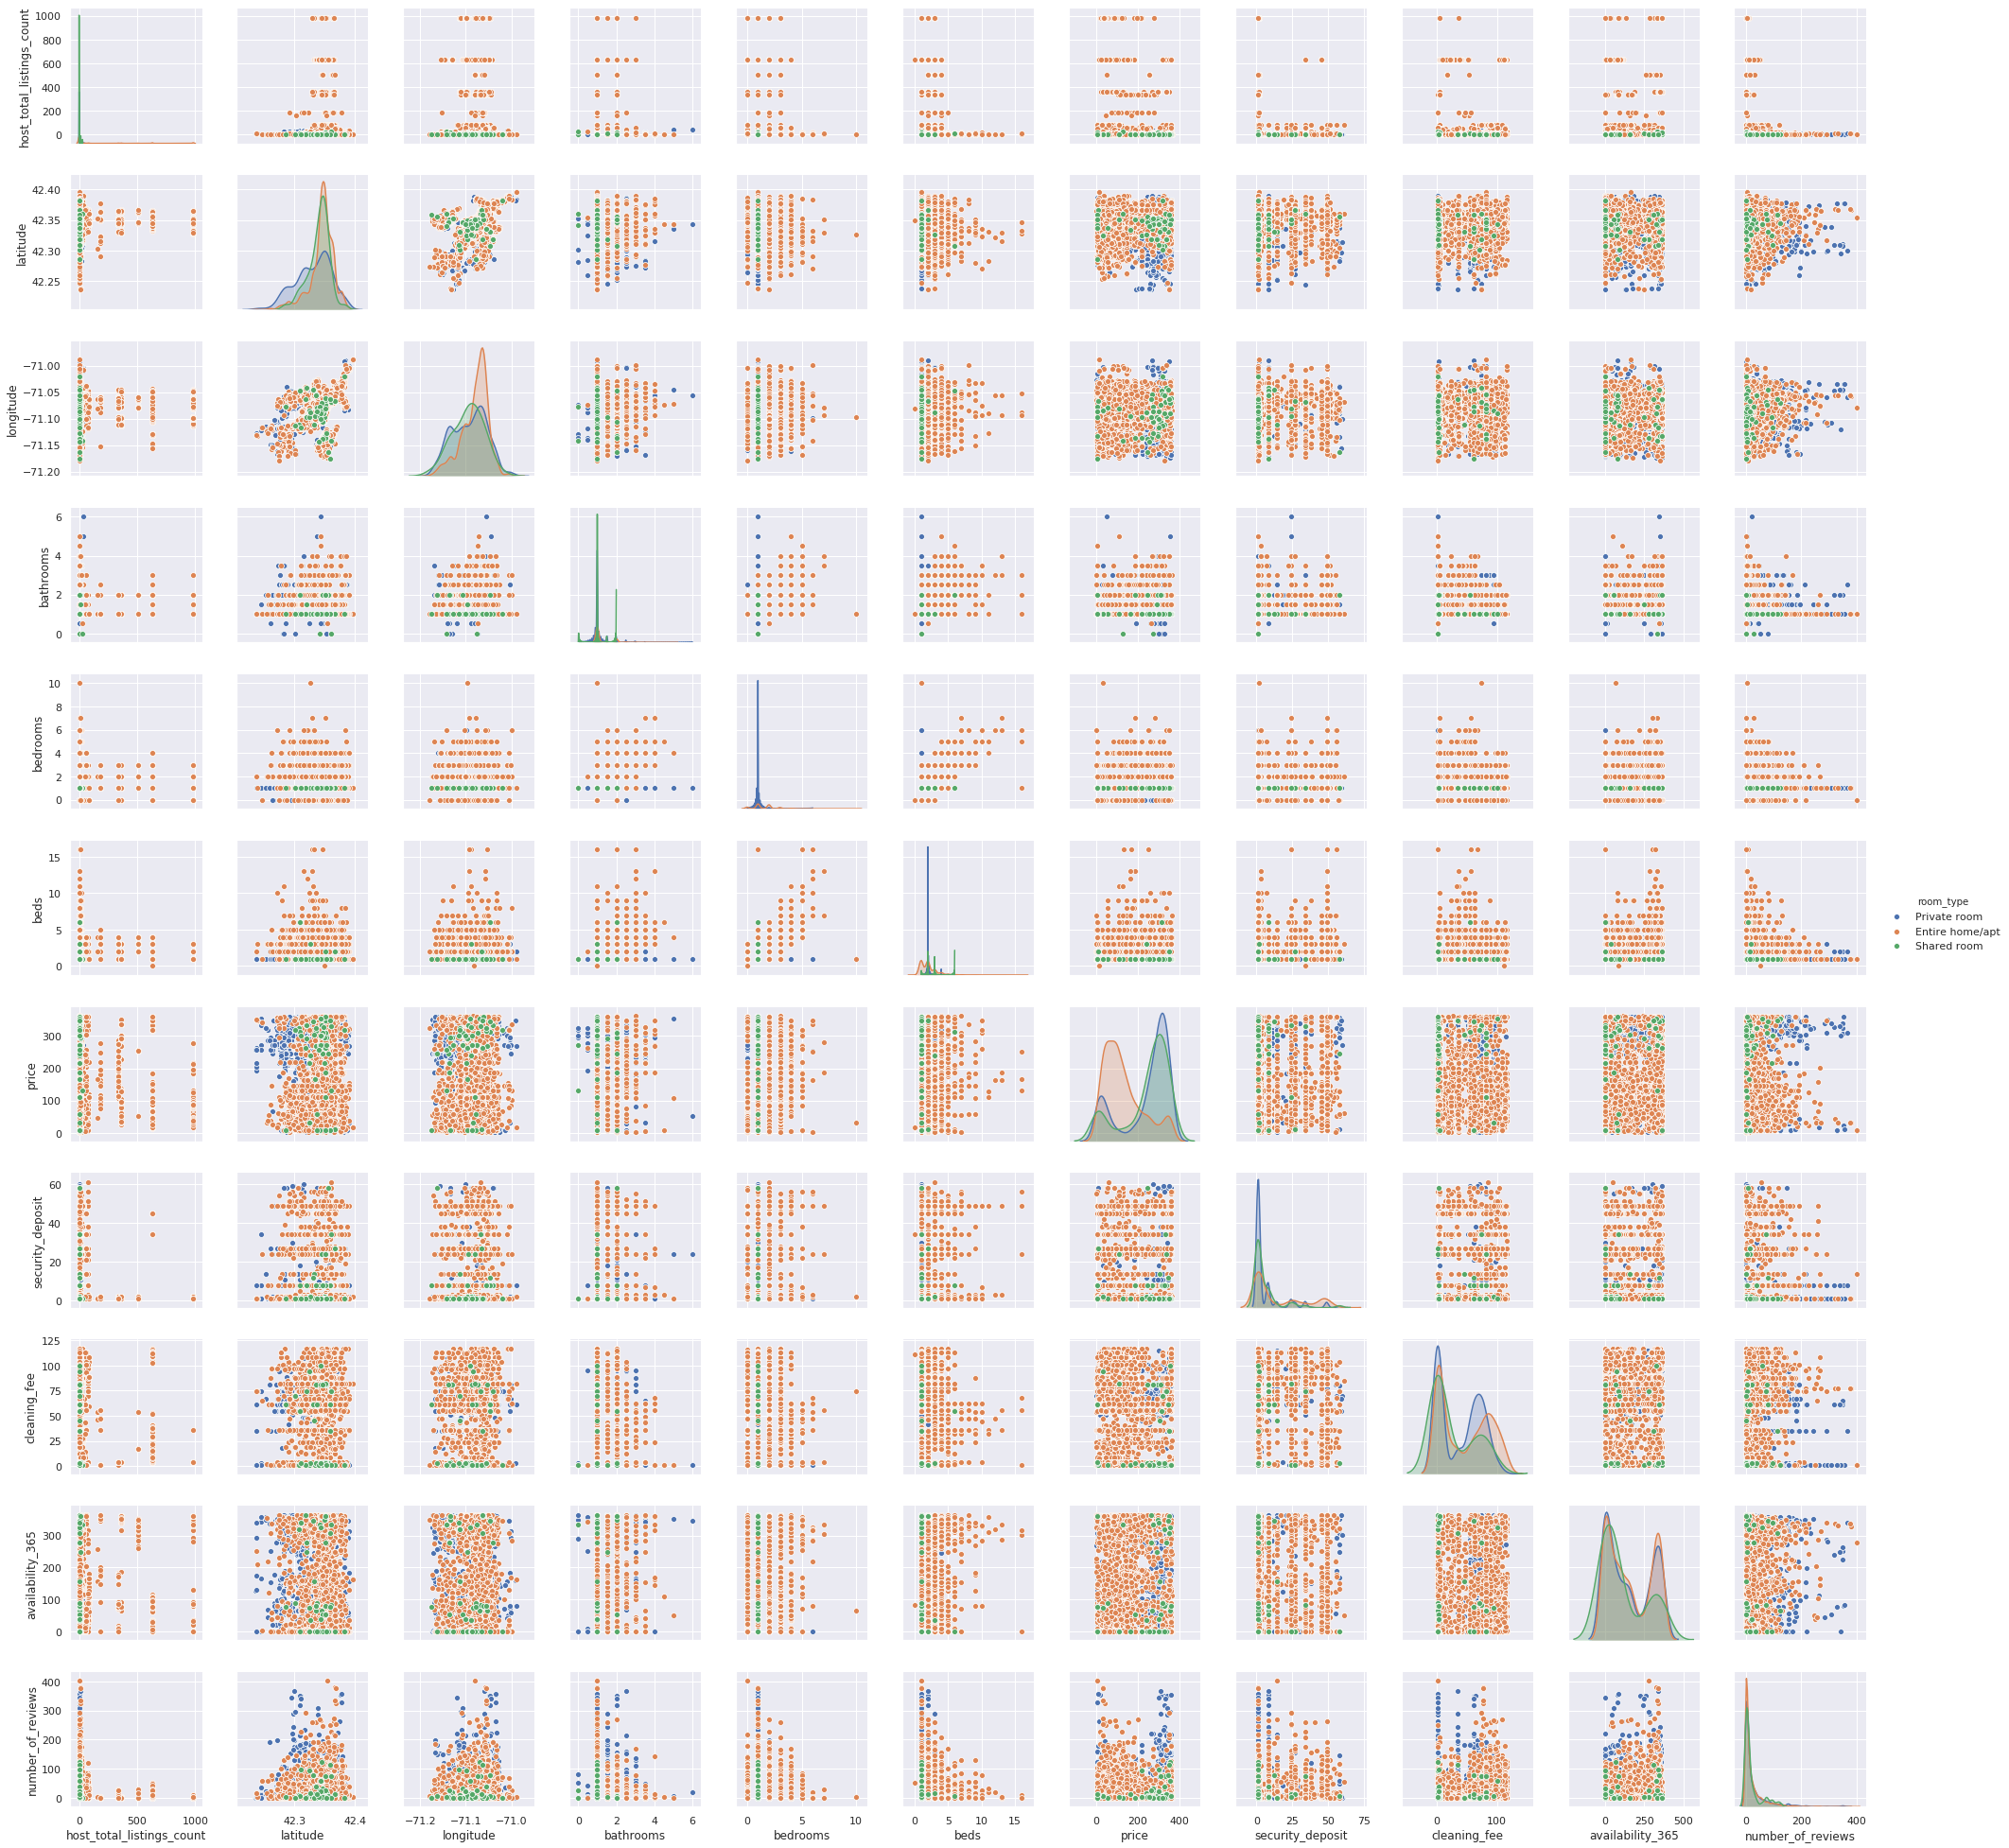

In [11]:
sns.set()

category = ["room_type", "bedrooms", "bathrooms", "beds"]

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,45))

for i, col in enumerate(category):
    sns.boxplot(x=col, y="price", hue="room_type", data=listing_train, ax=ax[i])
    if col == 'room_type':
        continue
    #sns.lmplot(x=col, y="price", data=listing_train);
    #sns.relplot(x=col, y="price", col="room_type", hue="beds", data=listing_train)

fig.show()

numerics = ["host_total_listings_count", "security_deposit", "cleaning_fee", "availability_365", 
            "number_of_reviews", 'latitude', 'longitude']
for col in numerics:
    sns.lmplot(x=col, y="price", col="room_type", order=1, sharex=False, ci=None, x_estimator=np.mean, robust=True,
               data=listing_train)


sns.pairplot(listing_train, hue="room_type")

# Analysis

#### Comment
* **Boxplots use the indivudual data points, where as scatter plots and regression lines only use daily average data for better visualization.**
* **All the plots have been stratified on Room Types as relationship may vary depending on the room type.**


1. **Room Type**
    - While three room types seem to have similar overall price range. However, the mean, the standard devation and the distribution are significantly apart from each other.
    - Room Type should be a seperate factor term, and ideally should be used as an interaction term or decision tree stump for fitting different models for the different room types.
    

2. **Bedrooms**
    - Number of bedrooms is not relevant in case of shared room.
    - Both in case of private room and entire apartment, number of bedrooms is a relevant factor with seemingly non-linear relationship.
    - The distribution, however is different between private room annd entire apartment.
    
    
3. **Bathrooms**
    - Numner of bathroom seems to have non-linear relationship in case of shared and private rooms.
    - In case of entire apartment, there is a strong positive and seemingly linear relationship between price and number of bathrooms, except at the extreme which may be either due to noise or due to non-linear relationship.
    - Also it is worth exploring if number of bathrooms have any indepented effect after accounting for number of bedrooms. It may just be a proxy for number of bedroom and/or size of the apartment.


4. **Beds**
    - In case of shared room there seems to be negative relationship between price and number of beds.
    - In case of private rooms and entire apartments, the relationship effect is likely non-linear.
    
    
5. **Nunber of Reviews**
    - Number of reviews seems to have positive relationship with price for private and share rooms and negative rooms in case of entire apartments.
    - Its hard to say if there is any non-linear element to the relationship.
    - Further, it will be preferable to look at the review rating along with the number of reviews. Large number of reviews with mostly postive ratings should have different price impact versus large number of reviews with mostly negative ratings. Unless number of reviews itself is an indicator of the review rating.


6. **Following predictors most likely do not have any meanigful relationship with the response variable. The relation ship my be significant after accounting for the effect of the 5 variables above or when used jointly i.e. combination of latitude and longitude.**
    - Host Total Listings Count
    - Security Deposit
    - Cleaning Fee
    - Availability
    - Latitude
    - Longitude

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2EDA
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>very good
</span></div></div>

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [12]:
#your code here
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

train_list = listing_train.drop(labels=['room_type'], axis=1)
test_list = listing_test.drop(labels=['room_type'], axis=1)

room_type = OneHotEncoder(drop='first', sparse=False).fit(listing_train.room_type.to_numpy().reshape(-1,1))
room_type_train = pd.DataFrame(room_type.transform(listing_train.room_type.to_numpy().reshape(-1,1)))
room_type_test = pd.DataFrame(room_type.transform(listing_test.room_type.to_numpy().reshape(-1,1)))
room_type_train.columns = 'room_type' + room_type_train.columns.astype(str)
room_type_test.columns = 'room_type' + room_type_test.columns.astype(str)

train_lin = pd.concat([room_type_train, train_list], axis=1)
test_lin = pd.concat([room_type_test, test_list], axis=1)

terms = [x for x in train_lin.columns if x != 'price']
formula = "+".join(terms)
formula = 'price ~ {}'.format(formula)

reg = sm.ols(formula=formula, data=train_lin).fit()

r_score_train = r2_score(train_lin.price, reg.predict(train_lin))
r_score_test = r2_score(test_lin.price, reg.predict(test_lin))

print('\n###########################################################\n')
print("Linear Regression - Using One Hot Encoding")
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(reg.summary())


room_type = LabelEncoder().fit(listing_train.room_type.to_numpy().reshape(-1,1))
room_type_train = pd.DataFrame({'room_type': room_type.transform(listing_train.room_type.to_numpy().reshape(-1,1))})
room_type_test = pd.DataFrame({'room_type': room_type.transform(listing_test.room_type.to_numpy().reshape(-1,1))})

train_lin = pd.concat([room_type_train, train_list], axis=1)
test_lin = pd.concat([room_type_test, test_list], axis=1)

terms = [x for x in train_lin.columns if x != 'price']
formula = "+".join(terms)
formula = 'price ~ {}'.format(formula)

reg = sm.ols(formula=formula, data=train_lin).fit()

r_score_train = r2_score(train_lin.price, reg.predict(train_lin))
r_score_test = r2_score(test_lin.price, reg.predict(test_lin))

print('\n###########################################################\n')
print("Linear Regression - Using Label Encoding")
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(reg.summary())


poly = PolynomialFeatures(degree=3, include_bias=False)
train_poly = pd.DataFrame(poly.fit_transform(train_list.drop(labels=['price'], axis=1)))
test_poly = pd.DataFrame(poly.transform(test_list.drop(labels=['price'], axis=1)))
train_poly.columns = 'poly' + train_poly.columns.astype(str)
test_poly.columns = 'poly' + test_poly.columns.astype(str)
train_poly['price'] = train_list.price
test_poly['price'] = test_list.price


train_poly = pd.concat([room_type_train, train_poly], axis=1)
test_poly = pd.concat([room_type_test, test_poly], axis=1)

terms = [x for x in train_poly.columns if x != 'price']
formula = "+".join(terms)
formula = 'price ~ {}'.format(formula)

poly_reg = sm.ols(formula=formula, data=train_poly).fit()

r_score_train = r2_score(train_poly.price, poly_reg.predict(train_poly))
r_score_test = r2_score(test_poly.price, poly_reg.predict(test_poly))

print('\n###########################################################\n')
print("Polynomial Regression - Using Label Encoding")
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(poly_reg.summary())


###########################################################

Linear Regression - Using One Hot Encoding
Training R-Squared = 0.24942
Testing R-Squared = 0.18479

###########################################################

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     120.7
Date:                Thu, 06 Feb 2020   Prob (F-statistic):          1.45e-260
Time:                        13:54:09   Log-Likelihood:                -26307.
No. Observations:                4370   AIC:                         5.264e+04
Df Residuals:                    4357   BIC:                         5.272e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                            

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



###########################################################

Polynomial Regression - Using Label Encoding
Training R-Squared = 0.35540
Testing R-Squared = 0.20570

###########################################################

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     8.305
Date:                Thu, 06 Feb 2020   Prob (F-statistic):          1.80e-233
Time:                        13:54:12   Log-Likelihood:                -25975.
No. Observations:                4370   AIC:                         5.250e+04
Df Residuals:                    4097   BIC:                         5.424e+04
Df Model:                         272                                         
Covariance Type:            nonrobust                          

# Analysis

* **Polynomial Regression performs significantly better than linear regression when comparing $Training R^{2}$.**
* **However, when comparing $Testing R^{2}$ the performance gap is relatively minor.**

Model| Training $R^{2}$ | Testing $R^{2}$ 
-----|------------------|----------------
Linear Regression (with one-hot encoding)| 0.2494 | 0.1848
Linear Regression (with label encoding)| 0.2416 | 0.1813 
Polynomial Regression (with label encoding)| 0.3554 | 0.2057

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2a
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>good
</span></div></div>

### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


# Analysis

### Answer 2b 1.

**There is a merit in fitting an additive regression model to this data because of the following:**

1. From the detailed analysis of visualizations, we already know that there are likely four to five predictor variables (and maybe more) that may have non-linear relationship with the price.

2. Linear Regression above does a poor job of explaing the variance - Less than 25% for the training data and less than 20% for the test data. This combined with above points toward underfitting.

3. Polynomial Regression while explaining about a third of the variance in the training set, performs as miserably for test set at just a little above 20% variance explanation. Clearly overfitting is an issue.

4. We need a model which does a better job of capturing non-linearity while avoiding the overfitting asociated with the Polynomial Regression. 

**Hence GAM!**

In [13]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
#your code here

print('Columns of the Dataset: \n   {}'.format("\n   ".join(train_lin.columns)))

airbnb_train = train_lin
airbnb_test = test_lin

smoothings = np.logspace(-3, 6, 9)
cv = 10

kf = KFold(n_splits=cv, random_state=42, shuffle=True)
scores = np.zeros((cv,len(smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(airbnb_train)):
    train_df = airbnb_train.iloc[train_index,:]
    test_df = airbnb_train.iloc[test_index,:]
    
    for j, smoothing in enumerate(smoothings):
        cur_model = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(8) + s(9) + s(10) + s(11),
                              lam=smoothing).fit(train_df, train_df.price)
        scores[i,j] = r2_score(test_df.price, cur_model.predict(test_df))


best_lambda = smoothings[np.argmax(np.mean(scores, axis=0))]

airbnb_gam = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(8) + s(9) + s(10) + s(11),
                       lam=best_lambda).fit(airbnb_train, airbnb_train.price)
r_score_train = r2_score(airbnb_train.price, airbnb_gam.predict(airbnb_train))
r_score_test = r2_score(airbnb_test.price, airbnb_gam.predict(airbnb_test))


print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(airbnb_gam.summary())

Columns of the Dataset: 
   room_type
   host_total_listings_count
   latitude
   longitude
   bathrooms
   bedrooms
   beds
   price
   security_deposit
   cleaning_fee
   availability_365
   number_of_reviews

###########################################################

Lambda = 31.623
Training R-Squared = 0.28242
Testing R-Squared = 0.24502

###########################################################

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      65.083
Link Function:                     IdentityLink Log Likelihood:                                -44098.3463
Number of Samples:                         4370 AIC:                                            88328.8586
                                                AICc:    

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



# Analysis

* **With $Training R^{2}$ of 0.2824, Linear GAM performs better than Linear Regression but worse than Polynomial Regression in case of training data.**
* **However, when using test set, Linear GAM outperforms both Linear Regression and Polynomial Regression with $Testing R^{2}$ of 0.2450 i.e. GAM gets rid of atleast some of the overfitting in comparison to the Polynomial Regression.**


Linear GAM Parameter|Specification
--|--
K - number of cross-validation folds| 10
$\lambda$|31.6228
Feature Functions|room_type
Spline Functions|host_total_listings_count
   |latitude
   |longitude
   |bathrooms
   |bedrooms
   |beds
   |price
   |security_deposit
   |cleaning_fee
   |availability_365
   |number_of_reviews
Effective DoF|65.083


Model| Training $R^{2}$ | Testing $R^{2}$ 
-----|------------------|----------------
Linear Regression (with one-hot encoding)| 0.2494 | 0.1848
Linear Regression (with label encoding)| 0.2416 | 0.1813 
Polynomial Regression (with label encoding)| 0.3554 | 0.2057
Linear GAM (with label encoding)| 0.2824 | 0.2450

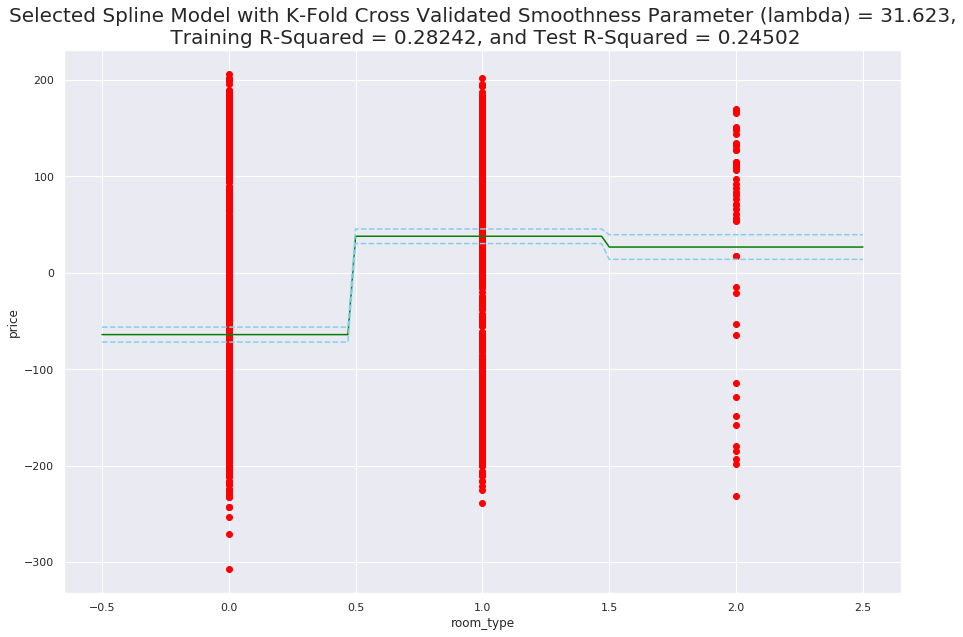

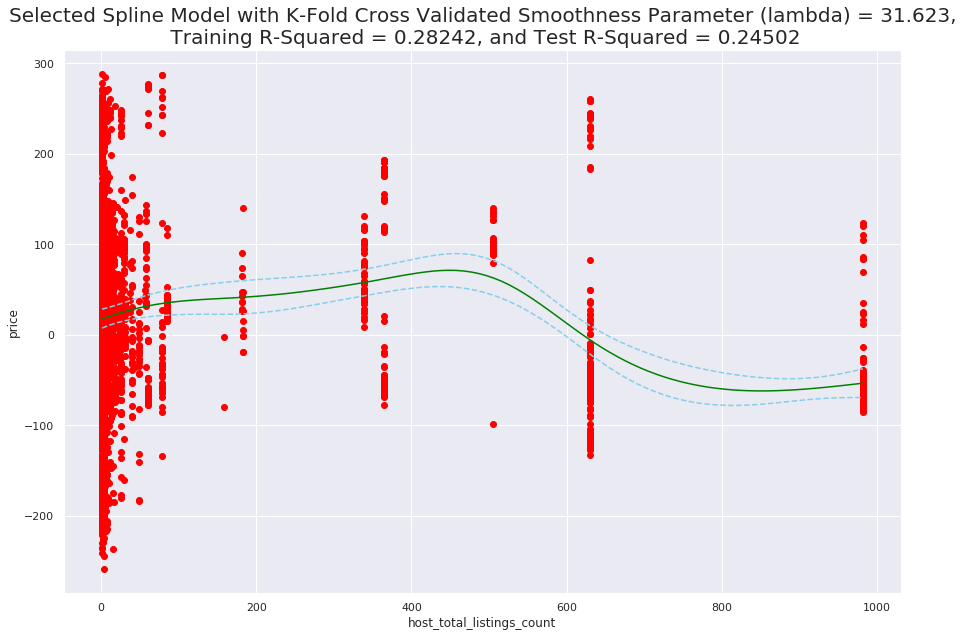

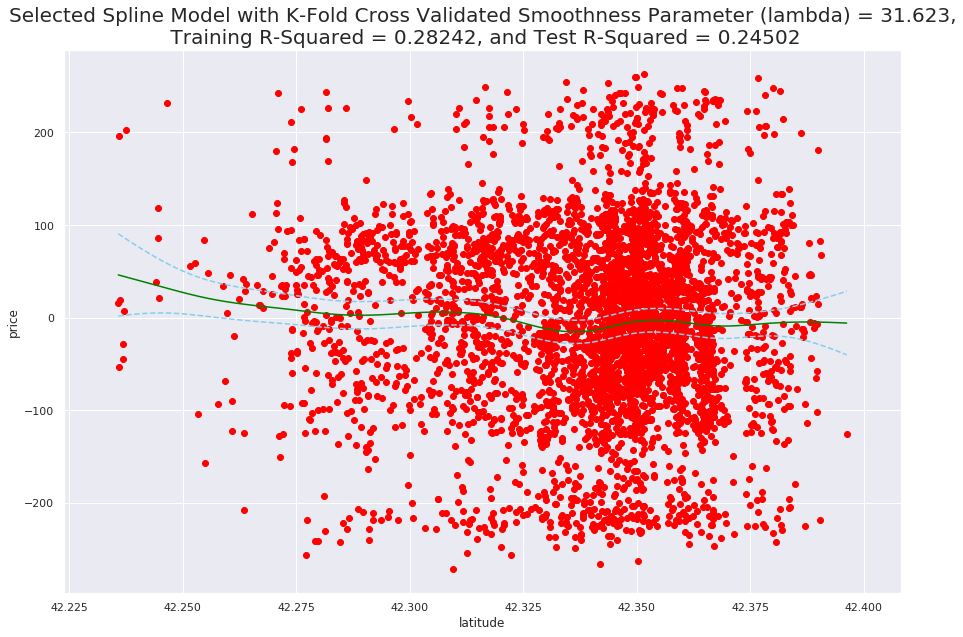

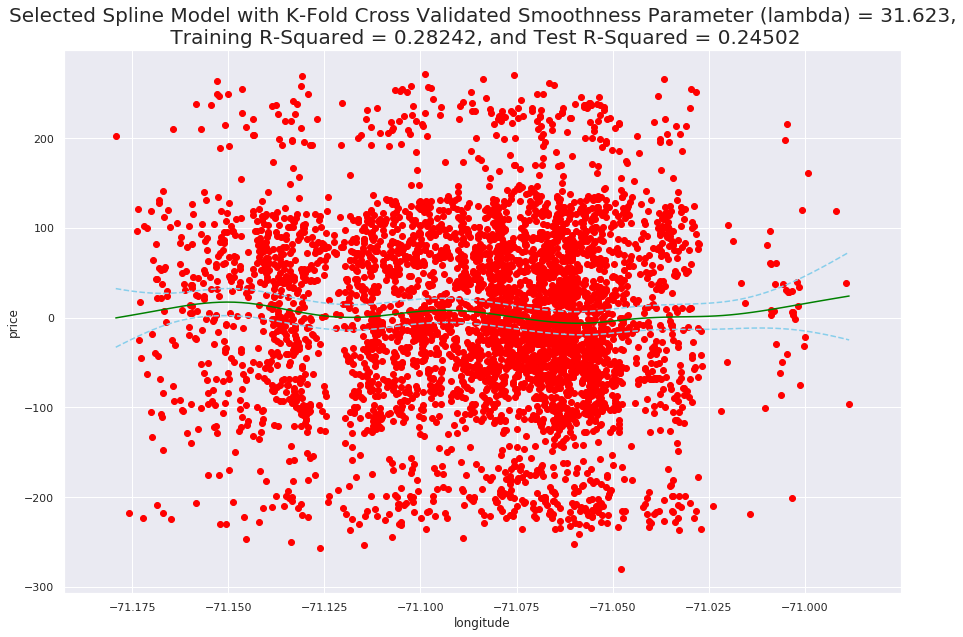

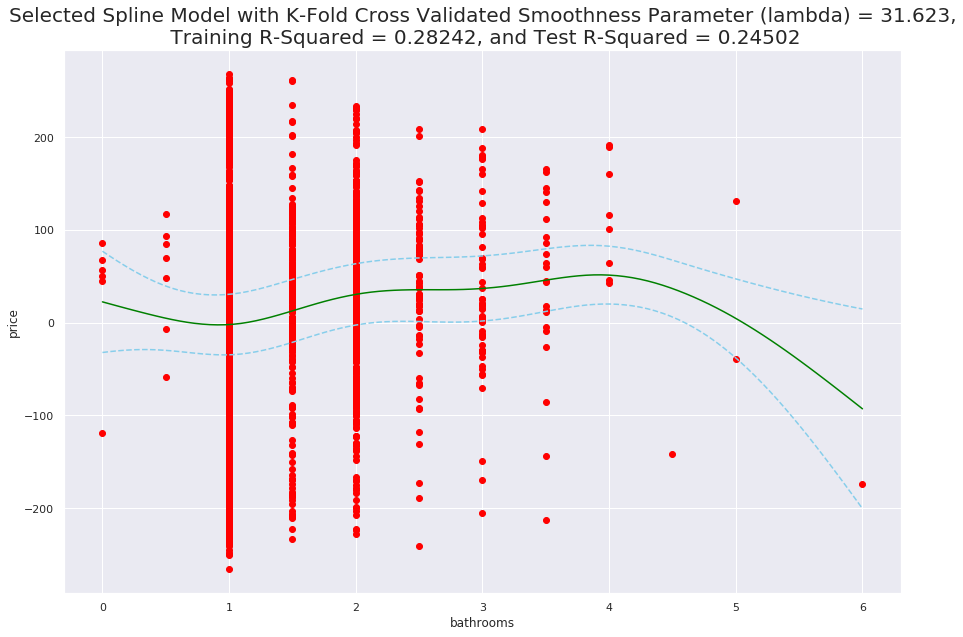

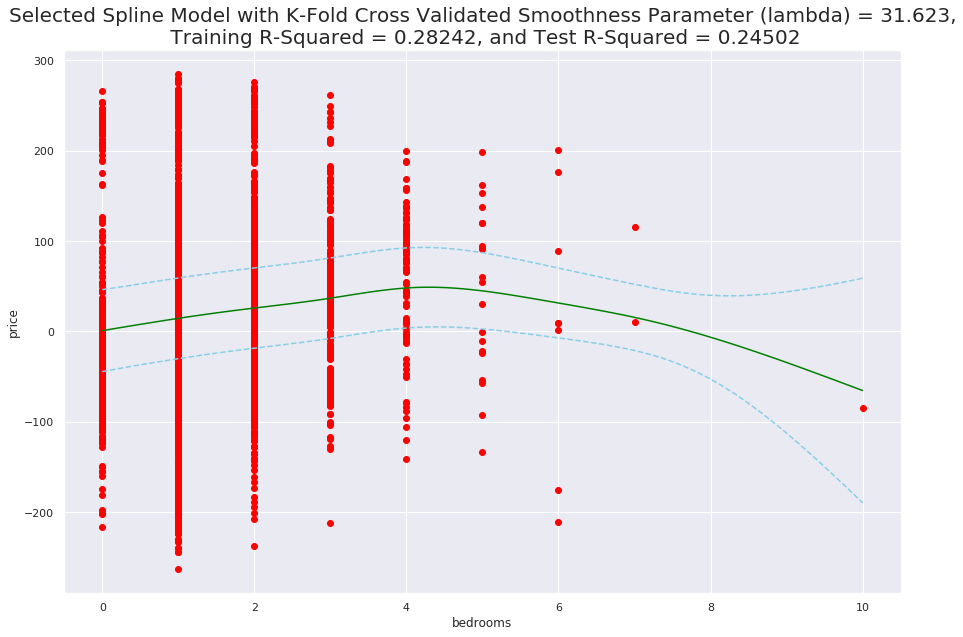

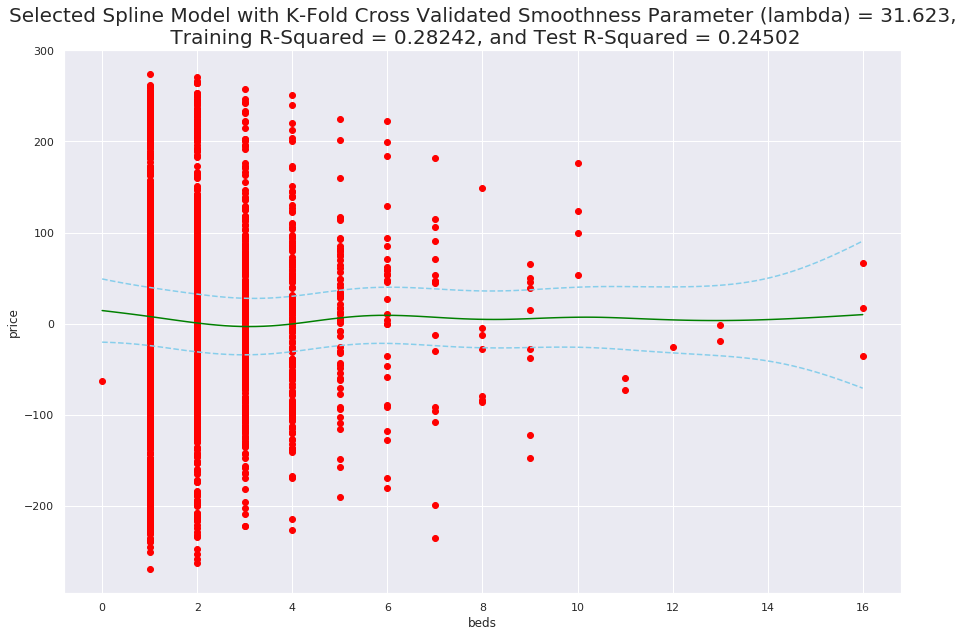

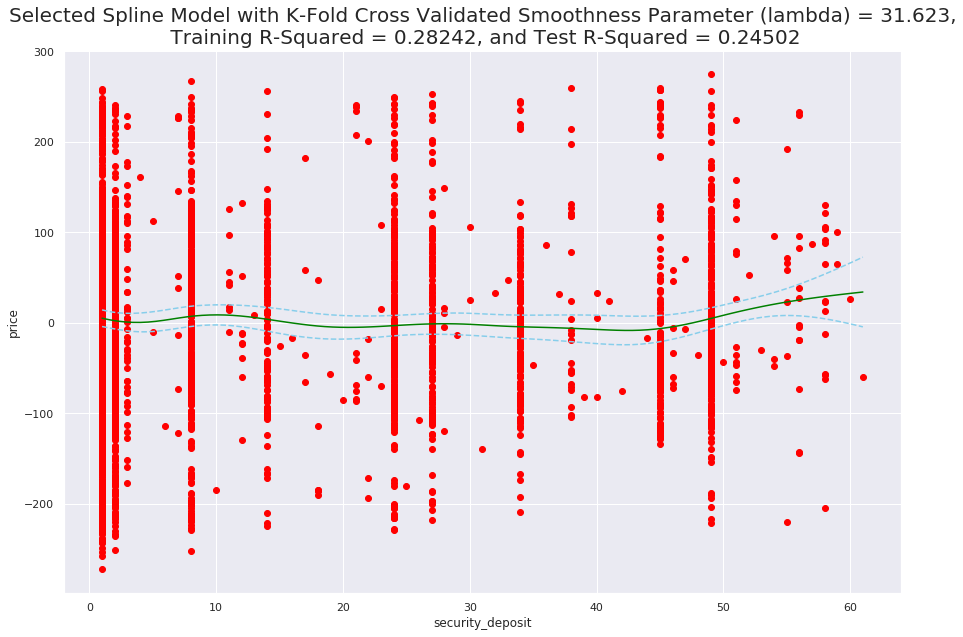

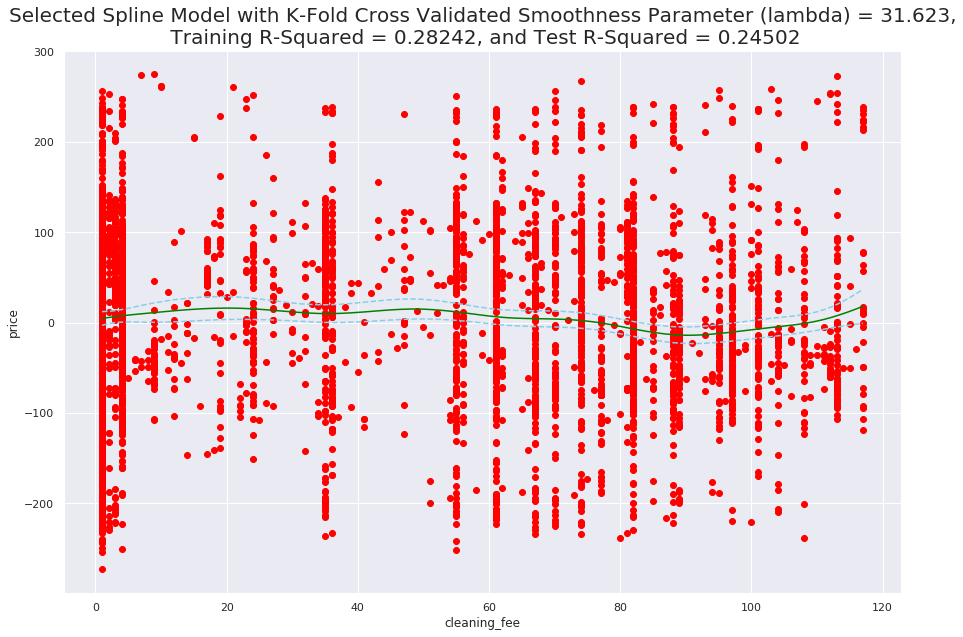

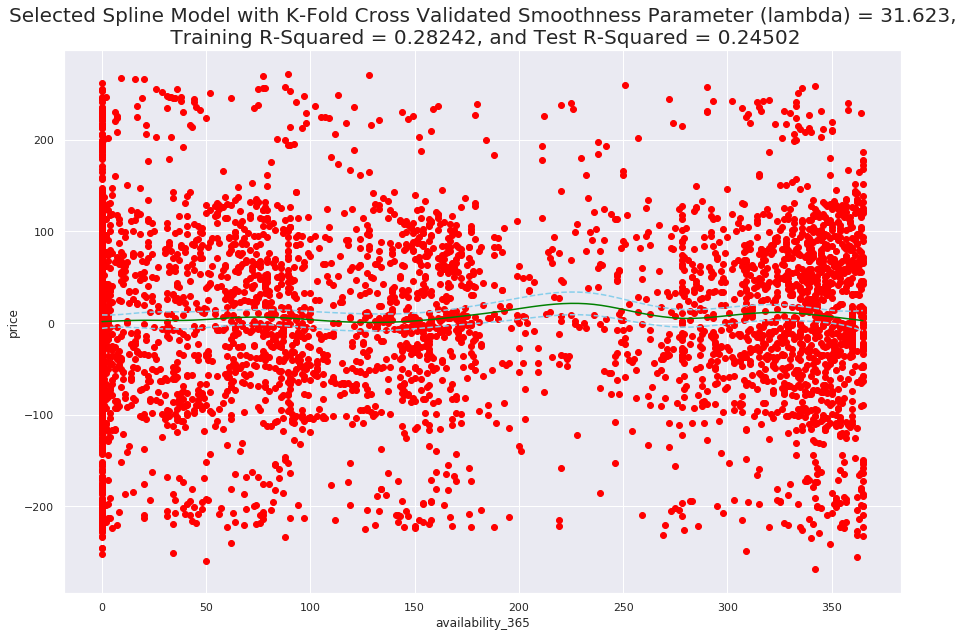

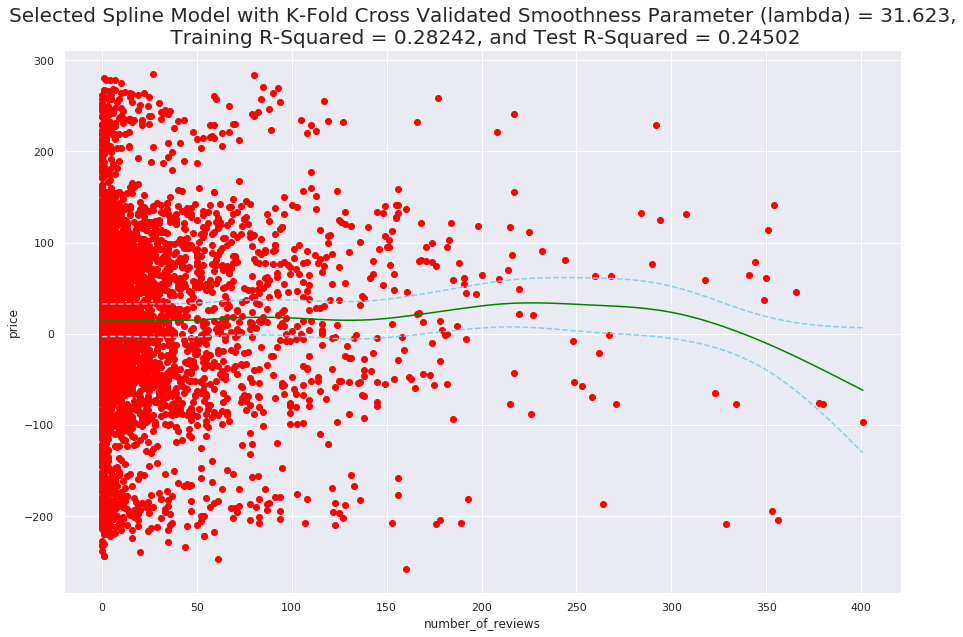

In [14]:

res = airbnb_gam.deviance_residuals(airbnb_train, airbnb_train.price)
for i, term in enumerate(airbnb_gam.terms):
    if term.isintercept:
        continue

    XX = airbnb_gam.generate_X_grid(term=i)
    pdep, confi = airbnb_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = airbnb_gam.partial_dependence(term=i, X=airbnb_train, width=0.95)
    plt.figure(figsize=(15,10))
    plt.scatter(airbnb_train.iloc[:,term.feature], pdep2 + res, c='red')
    plt.plot(XX[:, term.feature], pdep, c='green')
    plt.plot(XX[:, term.feature], confi, c='skyblue', ls='--')
    plt.title('Selected Spline Model with K-Fold Cross Validated Smoothness Parameter (lambda) = ' +
              '{:0.3f},\n Training R-Squared = {:0.5f}, and Test R-Squared = {:0.5f}'.format(best_lambda, 
                                                                                             r_score_train, 
                                                                                             r_score_test),
              fontsize=20)
    
    plt.xlabel(airbnb_train.columns.values[term.feature])
    plt.ylabel('price')
    plt.show()

# Analysis

#### Critical Observation
1. We are fitting a feature function on "Room Type" and spline function on other features.

2. From visualizations we know that most features have different distributions across the room types

3. Ideally, we should be including tensor terms between room type and other features to capture the effect of the interactions.


#### Insights from the plot of each predictor for the fitted GAM

* Room type taken as a factor has a non-linear relationship with price.

* Total listings count also has a similar non-linear effect on the price with price decreasing with increasing listings - pointing to the presence of "airbnb landlords".

* It will be better to fit a tensor term between latitude and longitude. Spline fit is not very informative.

* Bedroms and bathrooms both have an initially increasing and subsequently decreasing relaitonship.

* Most other factors seems to be non-informative, except possible non-linear relationship in case of number of reviews. Using tensor function with price should be more informative.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2b
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>very good
</span></div></div>

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

# Analysis

#### Most important variables that are driving prices
1. Room Type
2. Weekend or Weekday
3. Host Total Listing Counts
4. No of Bedrooms
5. No of Bathrooms
6. To a lesser extent:
    - No of reviews
    - Major events on or around the dates


#### Recommendations for the frugal traveller

1. Look for entire apartments/houses. They are considerably cheaper; there maybe variety of reasons behind this. For example, it maybe beacuse of the location or landlords living out of town and either less imformed or more motivated to maximize the revenue, etc. So do not filter out choices for "entire apartment" when looking to book; especially for large groups as pointed out by prices for houses wiht higher number of bedrooms.

2. Avoid weekends, particularly long weekends. Wednesday is on average the cheapest night.

3. Boston Marathon weekend is the most expensive time to rent a place in Boston.

4. December to February is the best time to travel. March and November are slightly more expensive. April and may are the most expensive followed by June to October period.

5. Look for staying with "super-hosts" aka "airbnb landlords" or people with large number of listings since they may be able to give you lower prices.

6. If you are visiting Boston for the summer then please come towards the end of summer and in the middle of the week since weekday prices are higher. Sunday would be a good day to start your holiday since prices start to reduce and stay low through the week.

# END

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2c
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>good 
</span></div></div>

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Graded by: Jun Yin
</footer>